# Topic Modelling

A very nice explanation
- https://www.youtube.com/watch?v=MGVdu39gT6k  or https://github.com/adashofdata/nlp-in-python-tutorial  
- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/  
- https://www.coursera.org/lecture/python-text-mining/topic-modeling-KiiBl   
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24  
- https://dzone.com/articles/interactive-topic-modeling-using-python
- https://nlpforhackers.io/topic-modeling/
- https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
- https://towardsdatascience.com/it-support-ticket-classification-and-deployment-using-machine-learning-and-aws-lambda-8ef8b82643b6  
- https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec/data#3)-Model-Training-
- https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda
- https://github.com/pankajkishore/Cognitive-Project/blob/master/Support_Ticket_Classification.ipynb

# Tokenization
- http://feedproxy.google.com/~r/AnalyticsVidhya/~3/HijRs9SFo-8/?utm_source=feedburner&utm_medium=email

In [28]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style


In [68]:
pd.set_option('max_colwidth', -1)

In [29]:
data = pd.read_csv('latest_ticket_data.csv')
print(data.shape)
data.head()

(3000, 2)


,Description,Category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application


# 1- Feature Inspection  

In [30]:
# check if there's missing data
data.isnull().sum()

Description    0
Category       0
dtype: int64

In [31]:
data.Category.value_counts()

User Maintenance    600
Database            600
Security            600
Application         600
Network             600
Name: Category, dtype: int64

### Inspect text variable

In [32]:
document_lengths = np.array(list(map(len, data.Description.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 35.323.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 927.


Note how there's actually a document with just two words. That is going to be interesting to classify. Let's dig in a little bit deeper and see the distribution of the number of words in a document.

In [33]:
document_lengths

array([ 12, 140,  14, ...,  96, 263,  57])

C:\Users\tshrs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


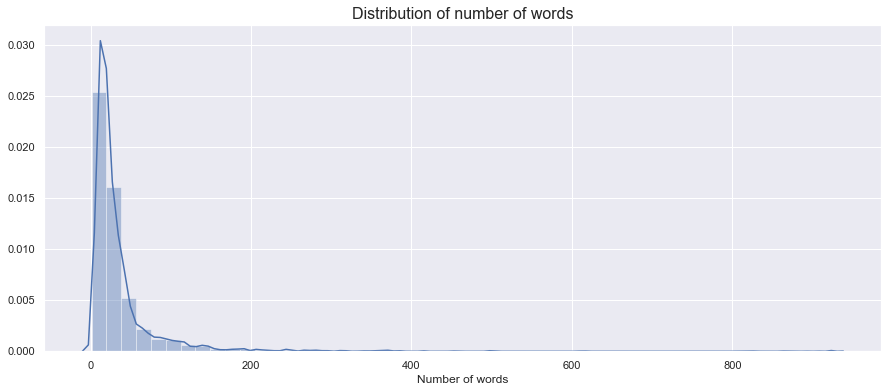

In [34]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);


In [35]:
print("There are {} documents with over 150 words.".format(sum(document_lengths > 150)))

shorter_documents = document_lengths[document_lengths <= 150]

There are 79 documents with over 150 words.


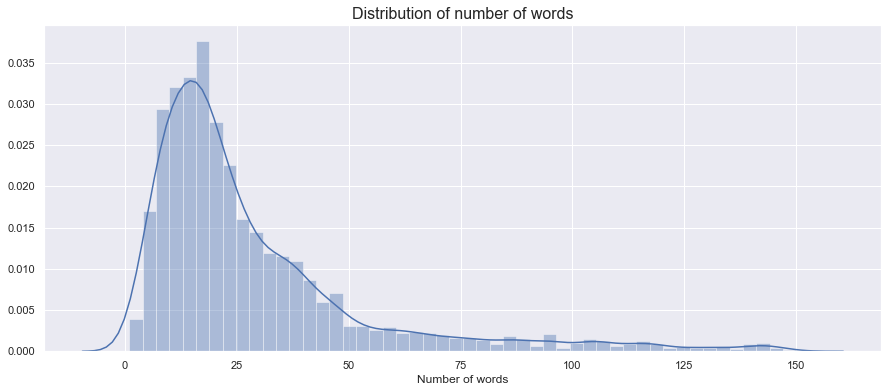

In [36]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

This makes it a bit clearer. The shorter documents will probably be harder to classify since we'll have less words to cling to. LDA for example tries to find topics in documents, but if the documents are so short, perhaps it will find it hard to really find a topic in a two-word document.
Apparently there's actually quite some short documents. Let's just have a quick peek at some of these documents.

In [37]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))

There are 132 documents with tops 5 words.


In [38]:
data[document_lengths == 2]

,Description,Category
288,se ca,Application
396,snow lux,Application
520,normal va,Application
818,leaver form,Database
1278,card si,User Maintenance
1427,card va,User Maintenance
1447,va maine,User Maintenance
1450,leaver card,User Maintenance
1833,si el,Security
2486,working laptop,Network


In [39]:
data[document_lengths == 3]

,Description,Category
282,contacted via phone,Application
349,hi please thank,Application
510,dear browse thank,Application
624,subscription professional azure,Database
743,la la si,Database
912,requested write similar,Network
990,repository accessing over,Network
1236,card leaver va,User Maintenance
1241,card si ca,User Maintenance
1277,si si va,User Maintenance


Looks like there are is rarely a random sentence.

# 2- Feature Creation / Cleansing

The most common steps to take in order to achieve this cleansing.

1- **Tokenize** the text; split sentences in (good) words. Thus watch out for punctuation.  
2- **Remove words** that mean little; these are usually words that occur very frequently or words that occur very infrequently. Also, punctuation can be removed, but perhaps you'd like to keep some punctuation in, like exclamation marks or question marks since maybe one writer uses them more than others.  
3- **Stemming**; this basically means joining words that mean the same. Take for example the words running and runs, the stem of both words is run. Thus with stemming you'd group these words together and give them the same meaning for the model.  
4- **Vectorize** words; since we can't input plain words into a model and expect it to learn from it, we have to vectorize the words. This basically means create unit vectors for all words.
  
For LDA you'd like to perform all four steps. However, for w2v you'd only want to tokenize and remove some punctuation. The w2v model can determine by itself what words are important and what are not, but we'll get back to that later on.

## 2.1 - Tokenize the text

ASCII, pronounced ask-ee, stands for the American Standard Code for Information Interchange. ASCII was originally based on the English alphabet and consists of 128 characters including A-Z, 0-9, punctuation, spaces, and other control codes that can be found on a standard English keyboard. These 128 characters are then assigned a number from 0 to 127 to represent them in data transfer from one computer to the other.  

Non-ASCII  
http://heima.olivant.fo/~styrheim/tools/non-ascii.html  
®  
ᛋᛏᚤᚱᚼᛂᛁᛘ

In [40]:
# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'description' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'Description'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'Description'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(data)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 0 words with characters with an ordinal >= 128 in the train data.


In [41]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [42]:
    data.head()

,Description,Category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application


In [43]:
data.style.set_properties(subset=['Description'], **{'width': '300px'})

In [44]:
data['document_sentences'] = data.Description.str.split('.')  # split texts into individual sentences
data.head()

,Description,Category,document_sentences
0,hi since recruiter lead permission approve req...,Application,[hi since recruiter lead permission approve re...
1,re expire days hi ask help update passwords co...,Application,[re expire days hi ask help update passwords c...
2,verification warning hi has got attached pleas...,Application,[verification warning hi has got attached plea...
3,please dear looks blacklisted receiving mails ...,Application,[please dear looks blacklisted receiving mails...
4,dear modules report report cost thank much reg...,Application,[dear modules report report cost thank much re...


In [45]:
data['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         data.document_sentences))  # tokenize sentences

In [46]:
data.head()

,Description,Category,document_sentences,tokenized_sentences
0,hi since recruiter lead permission approve req...,Application,[hi since recruiter lead permission approve re...,"[[hi, since, recruiter, lead, permission, appr..."
1,re expire days hi ask help update passwords co...,Application,[re expire days hi ask help update passwords c...,"[[re, expire, days, hi, ask, help, update, pas..."
2,verification warning hi has got attached pleas...,Application,[verification warning hi has got attached plea...,"[[verification, warning, hi, has, got, attache..."
3,please dear looks blacklisted receiving mails ...,Application,[please dear looks blacklisted receiving mails...,"[[please, dear, looks, blacklisted, receiving,..."
4,dear modules report report cost thank much reg...,Application,[dear modules report report cost thank much re...,"[[dear, modules, report, report, cost, thank, ..."


In [47]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['Description'] = df.Description.str.lower()
    df['document_sentences'] = df.Description.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(data)

In [48]:
data.head()

,Description,Category,document_sentences,tokenized_sentences
0,hi since recruiter lead permission approve req...,Application,[hi since recruiter lead permission approve re...,"[[hi, since, recruiter, lead, permission, appr..."
1,re expire days hi ask help update passwords co...,Application,[re expire days hi ask help update passwords c...,"[[re, expire, days, hi, ask, help, update, pas..."
2,verification warning hi has got attached pleas...,Application,[verification warning hi has got attached plea...,"[[verification, warning, hi, has, got, attache..."
3,please dear looks blacklisted receiving mails ...,Application,[please dear looks blacklisted receiving mails...,"[[please, dear, looks, blacklisted, receiving,..."
4,dear modules report report cost thank much reg...,Application,[dear modules report report cost thank much re...,"[[dear, modules, report, report, cost, thank, ..."


So we're actually already finished the word2vec preprocessing! All the following steps are preprocessing steps for LDA.

In [49]:
def lda_get_good_tokens(df):
    df['Description'] = df.Description.str.lower()
    df['tokenized_Description'] = list(map(nltk.word_tokenize, df.Description))
    df['tokenized_Description'] = list(map(get_good_tokens, df.tokenized_Description))

lda_get_good_tokens(data)

In [50]:
data.head()

,Description,Category,document_sentences,tokenized_sentences,tokenized_Description
0,hi since recruiter lead permission approve req...,Application,[hi since recruiter lead permission approve re...,"[[hi, since, recruiter, lead, permission, appr...","[hi, since, recruiter, lead, permission, appro..."
1,re expire days hi ask help update passwords co...,Application,[re expire days hi ask help update passwords c...,"[[re, expire, days, hi, ask, help, update, pas...","[re, expire, days, hi, ask, help, update, pass..."
2,verification warning hi has got attached pleas...,Application,[verification warning hi has got attached plea...,"[[verification, warning, hi, has, got, attache...","[verification, warning, hi, has, got, attached..."
3,please dear looks blacklisted receiving mails ...,Application,[please dear looks blacklisted receiving mails...,"[[please, dear, looks, blacklisted, receiving,...","[please, dear, looks, blacklisted, receiving, ..."
4,dear modules report report cost thank much reg...,Application,[dear modules report report cost thank much re...,"[[dear, modules, report, report, cost, thank, ...","[dear, modules, report, report, cost, thank, m..."


 
Let's view at the top word frequencies now and get an idea of the words that are used mostly. 
  

In [51]:
tokenized_only_dict = Counter(np.concatenate(data.tokenized_Description.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [52]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)
tokenized_only_df

,count
please,3573
regards,1495
hi,1415
thank,1376
hello,1265
card,1203
sent,1179
you,1129
re,1104
thanks,932


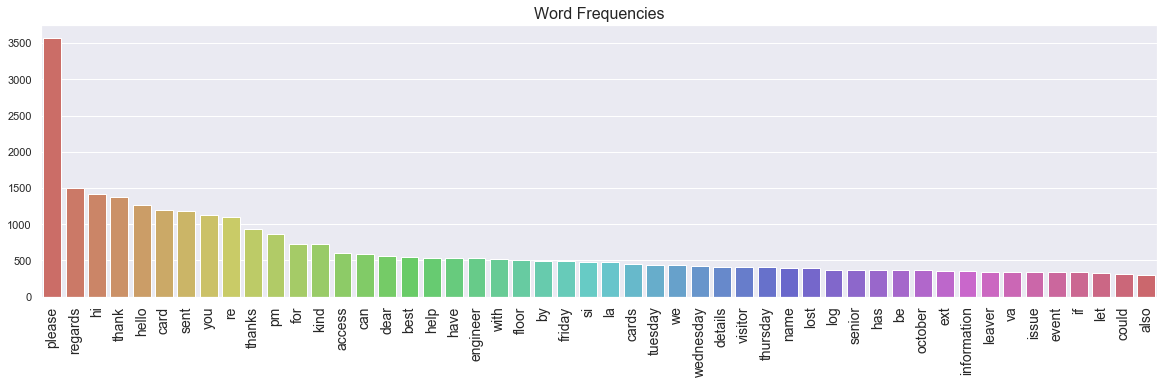

In [53]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

It was to be expected that simple words like 'the', 'of' and 'to' are words that are used often. Unless you think that one author would preferably use on of these words more often than other authors, it's safe to remove these words. Like we stated in point 2 above, we will remove frequent words and stopwords since they probably bring little meaning and maybe even create noise when we want to classify later on

## 2.2) Remove words that mean little
As stated above, words the have little meaning to the model are words we'd like to remove. Moreover, these words can create noise which can make it harder to classify the texts later on.

In [54]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_Description']))

remove_stopwords(data)

## 2.3) Stemming
For the stemming part, we'll start with lemmatization, this will stem words like leaves to leaf. Afterwards, we'll apply the porterstemmer which in turn will complete the stemming by converting words like running to run.

In [55]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

In [56]:
data.head()

,Description,Category,document_sentences,tokenized_sentences,tokenized_Description,stopwords_removed,lemmatized_text,stemmed_text
0,hi since recruiter lead permission approve req...,Application,[hi since recruiter lead permission approve re...,"[[hi, since, recruiter, lead, permission, appr...","[hi, since, recruiter, lead, permission, appro...","[hi, since, recruiter, lead, permission, appro...","[hi, since, recruiter, lead, permission, appro...","[hi, sinc, recruit, lead, permiss, approv, req..."
1,re expire days hi ask help update passwords co...,Application,[re expire days hi ask help update passwords c...,"[[re, expire, days, hi, ask, help, update, pas...","[re, expire, days, hi, ask, help, update, pass...","[expire, days, hi, ask, help, update, password...","[expire, day, hi, ask, help, update, password,...","[expir, day, hi, ask, help, updat, password, c..."
2,verification warning hi has got attached pleas...,Application,[verification warning hi has got attached plea...,"[[verification, warning, hi, has, got, attache...","[verification, warning, hi, has, got, attached...","[verification, warning, hi, got, attached, ple...","[verification, warning, hi, got, attached, ple...","[verif, warn, hi, got, attach, pleas, address,..."
3,please dear looks blacklisted receiving mails ...,Application,[please dear looks blacklisted receiving mails...,"[[please, dear, looks, blacklisted, receiving,...","[please, dear, looks, blacklisted, receiving, ...","[please, dear, looks, blacklisted, receiving, ...","[please, dear, look, blacklisted, receiving, m...","[pleas, dear, look, blacklist, receiv, mail, a..."
4,dear modules report report cost thank much reg...,Application,[dear modules report report cost thank much re...,"[[dear, modules, report, report, cost, thank, ...","[dear, modules, report, report, cost, thank, m...","[dear, modules, report, report, cost, thank, m...","[dear, module, report, report, cost, thank, mu...","[dear, modul, report, report, cost, thank, muc..."


## 2.4) Vectorize words
Here we create a dictionary for the model. Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. We use gensim.corpora.Dictionary for this.

In [57]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 3157 words.


In [72]:
dictionary.filter_extremes(no_above=0.3, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 1794 words.


In [73]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)
data.head()

,Description,Category,document_sentences,tokenized_sentences,tokenized_Description,stopwords_removed,lemmatized_text,stemmed_text,bow
0,hi since recruiter lead permission approve requisitions makes please make thanks recruiter,Application,[hi since recruiter lead permission approve requisitions makes please make thanks recruiter],"[[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisition, make, please, make, thanks, recruiter]","[hi, sinc, recruit, lead, permiss, approv, requisit, make, pleas, make, thank, recruit]","[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1)]"
1,re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing yours,Application,[re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing yours],"[[re, expire, days, hi, ask, help, update, passwords, colleagues, thank, pm, expire, days, importance, high, hi, received, about, expiration, please, kindly, help, prolongation, best, regards, pm, expire, days, importance, high, dear, expire, days, order, change, please, follow, steps, prerequisites, disable, device, credentials, close, active, connected, by, cable, machine, note, also, follow, steps, detailed, press, ctrl, alt, delete, same, pops, change, item, enter, format, enter, enter, newly, chosen, then, re, enter, again, submit, displaying, has, changed, os, machine, browse, enter, format, enter, gear, icon, top, tight, browser, window, enter, enter, newly, chosen, then, re, enter, again, save, connected, note, complete, resources, ...]]","[re, expire, days, hi, ask, help, update, passwords, colleagues, thank, pm, expire, days, importance, high, hi, received, about, expiration, please, kindly, help, prolongation, best, regards, pm, expire, days, importance, high, dear, expire, days, order, change, please, follow, steps, prerequisites, disable, device, credentials, close, active, connected, by, cable, machine, note, also, follow, steps, detailed, press, ctrl, alt, delete, same, pops, change, item, enter, format, enter, enter, new

In [60]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Visualize the cleansed words frequencies
Excellent! We cleansed our data and are ready to continue with LDA and Word2Vec, but before we do that, I would like to visualize the cleansed results and see what we created so far.

In [74]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [75]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

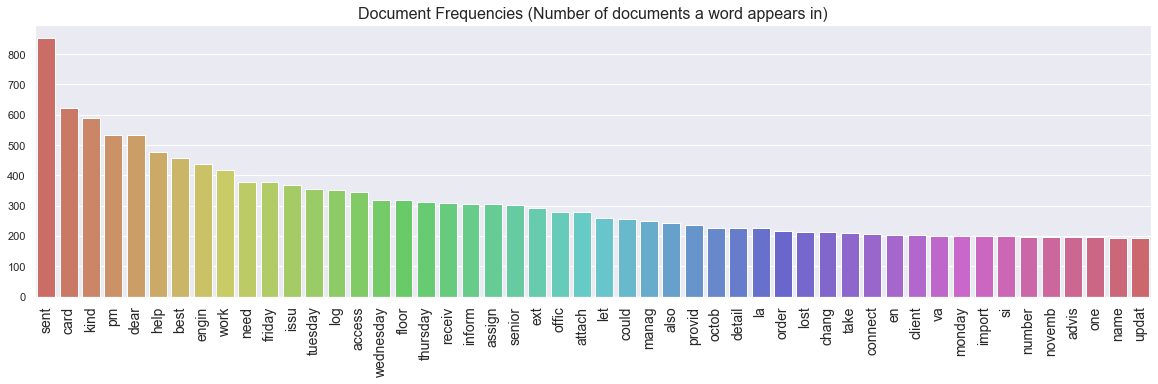

In [76]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

# 3) Model Training

## LDA

In [69]:
data.head()

,Description,Category,document_sentences,tokenized_sentences,tokenized_Description,stopwords_removed,lemmatized_text,stemmed_text,bow
0,hi since recruiter lead permission approve requisitions makes please make thanks recruiter,Application,[hi since recruiter lead permission approve requisitions makes please make thanks recruiter],"[[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisition, make, please, make, thanks, recruiter]","[hi, sinc, recruit, lead, permiss, approv, requisit, make, pleas, make, thank, recruit]","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1)]"
1,re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing yours,Application,[re expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing yours],"[[re, expire, days, hi, ask, help, update, passwords, colleagues, thank, pm, expire, days, importance, high, hi, received, about, expiration, please, kindly, help, prolongation, best, regards, pm, expire, days, importance, high, dear, expire, days, order, change, please, follow, steps, prerequisites, disable, device, credentials, close, active, connected, by, cable, machine, note, also, follow, steps, detailed, press, ctrl, alt, delete, same, pops, change, item, enter, format, enter, enter, newly, chosen, then, re, enter, again, submit, displaying, has, changed, os, machine, browse, enter, format, enter, gear, icon, top, tight, browser, window, enter, enter, newly, chosen, then, re, enter, again, save, connected, note, complete, resources, ...]]","[re, expire, days, hi, ask, help, update, passwords, colleagues, thank, pm, expire, days, importance, high, hi, received, about, expiration, please, kindly, help, prolongation, best, regards, pm, expire, days, importance, high, dear, expire, days, order, change, please, follow, steps, prerequisites, disable, device, credentials, close, active, connected, by, cable, machine, note, also, follow, steps, detailed, press, ctrl, alt, delete, same, pops, change, item, enter, format, enter, en

In [65]:
corpus = data.bow
corpus

0       [(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...
1       [(1, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12...
2       [(1, 1), (14, 1), (64, 1), (77, 1), (78, 1), (...
3       [(29, 1), (63, 1), (64, 1), (79, 1), (84, 1), ...
4       [(29, 1), (64, 1), (92, 1), (93, 1), (94, 1), ...
5       [(20, 1), (21, 1), (24, 1), (28, 2), (29, 2), ...
6                          [(104, 1), (131, 1), (132, 1)]
7       [(1, 1), (64, 1), (78, 1), (87, 1), (133, 1), ...
8       [(1, 1), (63, 2), (142, 1), (143, 2), (144, 1)...
9       [(3, 1), (14, 1), (22, 1), (53, 1), (98, 1), (...
10      [(14, 1), (18, 1), (50, 1), (58, 8), (64, 1), ...
11      [(1, 1), (14, 1), (42, 1), (64, 1), (79, 2), (...
12      [(8, 1), (14, 1), (50, 1), (58, 5), (64, 1), (...
13      [(1, 1), (14, 1), (42, 2), (57, 1), (58, 1), (...
14      [(2, 1), (18, 2), (29, 1), (58, 1), (64, 1), (...
15      [(41, 1), (42, 1), (63, 1), (132, 1), (215, 1)...
16      [(1, 1), (20, 1), (24, 1), (30, 1), (47, 1), (...
17      [(1, 1

In [66]:
%%time
num_topics = 5
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')
LDAmodel.print_topics()

Wall time: 48.1 s


[(0,
  '0.057*"card" + 0.023*"hello" + 0.023*"sent" + 0.020*"regard" + 0.019*"access" + 0.016*"si" + 0.016*"la" + 0.016*"visitor" + 0.015*"pm" + 0.015*"hi"'),
 (1,
  '0.027*"regard" + 0.024*"hi" + 0.021*"assign" + 0.020*"chang" + 0.017*"hello" + 0.016*"user" + 0.013*"pm" + 0.013*"kind" + 0.011*"dear" + 0.011*"best"'),
 (2,
  '0.030*"name" + 0.018*"upgrad" + 0.016*"host" + 0.016*"updat" + 0.015*"regard" + 0.013*"port" + 0.012*"hello" + 0.012*"best" + 0.011*"printer" + 0.010*"devic"'),
 (3,
  '0.025*"regard" + 0.022*"hi" + 0.015*"area" + 0.015*"floor" + 0.015*"leaver" + 0.013*"hello" + 0.012*"kind" + 0.012*"secur" + 0.012*"work" + 0.011*"test"'),
 (4,
  '0.026*"sent" + 0.015*"event" + 0.014*"connect" + 0.013*"issu" + 0.011*"detail" + 0.011*"hi" + 0.010*"error" + 0.009*"work" + 0.009*"problem" + 0.009*"log"')]

# Word2Vec

In [79]:
sentences = []
for sentence_group in data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 3001.
Number of texts: 3000.


In [83]:
sentences[0]

['hi',
 'since',
 'recruiter',
 'lead',
 'permission',
 'approve',
 'requisitions',
 'makes',
 'please',
 'make',
 'thanks',
 'recruiter']

In [86]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

Wall time: 3.34 s


In [87]:
W2Vmodel

In [93]:
import pprint as pp

In [121]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
##    pp.pprint(words)
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model

    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
##    pp.pprint(featureVec)
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [122]:
data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.tokenized_sentences))

C:\Users\tshrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [124]:
data.head(1)

,Description,Category,document_sentences,tokenized_sentences,tokenized_Description,stopwords_removed,lemmatized_text,stemmed_text,bow,w2v_features
0,hi since recruiter lead permission approve requisitions makes please make thanks recruiter,Application,[hi since recruiter lead permission approve requisitions makes please make thanks recruiter],"[[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisitions, makes, please, make, thanks, recruiter]","[hi, since, recruiter, lead, permission, approve, requisition, make, please, make, thanks, recruiter]","[hi, sinc, recruit, lead, permiss, approv, requisit, make, pleas, make, thank, recruit]","[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1)]","[-0.049193297, 0.07716945, 0.03272421, 0.0905764, 0.019792097, -0.027274491, -0.2760166, -0.23707066, 0.120455146, -0.14875275, -0.13555919, -0.091961056, -0.11135577, 0.11129276, 0.0040208115, 0.0016705327, -0.10548664, 0.0035920765, 0.13804756, 0.10646893, -0.10302659, 0.13013068, -0.10589704, -0.17034885, 0.13408923, -0.10501911, -0.043462753, -0.17800198, 0.082207054, -0.16345416, -0.15455988, 0.07563162, -0.090790555, 0.0116787935, -0.14930367, -0.2455617, -0.08238585, 0.008946437, -0.0009512001, 0.03211318, -0.14393009, -0.06298098, 0.13294715, -0.01280853, -0.1258228, 0.14260183, 0.30207336, 0.08886032, 0.041876864, -0.06400908, -0.07298967, -0.02003233, -0.1693838, -0.10724065, -0.19661444, 0.07935475, -0.03824334, -0.042404767, 0.3109802, 0.042200755, 0.07757009, -0.108789995, -0.106750555, 0.018927947, 0.1338944, -0.29993087, -0.23223016, 0.06818033, -0.00014699892, 0.11411599, 0.094527155, -0.2029444, -0.07776218, -0.15630442, 0.09085761, 0.016399764, 0.17523718, 0.065166265, 0.22774985, 0.103593335, 0.028143747, 0.22901052, 0.01510819, 0.046818417, 0.09128241, -0.14765586, -0.074798435, -0.21635903, -0.079151966, 0.10669276, 0.08995717, -0.014177246, -0.07525573, -0.15751228, -0.04224407, -0.15208885, 0.00744211, -0.031646047, 0.088527344, -0.050571747, ...]"


# Classification and hyperparameter tuning

In [125]:
label_encoder = LabelEncoder()

label_encoder.fit(data.Category)
data['Category_id'] = label_encoder.transform(data.Category)

In [128]:
data.Category_id.value_counts()

3    600
1    600
4    600
2    600
0    600
Name: Category_id, dtype: int64

In [129]:
X_train_w2v = np.array(list(map(np.array, data.w2v_features)))

In [130]:
X_train_w2v

array([[-0.0491933 ,  0.07716945,  0.03272421, ..., -0.00802489,
        -0.07836328,  0.01080266],
       [-0.19327049,  0.00684487, -0.00676499, ...,  0.09155223,
        -0.05233116,  0.03014123],
       [ 0.006495  , -0.00133446, -0.02182627, ..., -0.02518519,
        -0.01496637, -0.02039207],
       ...,
       [-0.12074519,  0.04811641,  0.00407194, ...,  0.00163907,
         0.02981647,  0.09988613],
       [-0.02279883,  0.07715113,  0.01283739, ..., -0.03830047,
         0.04837703,  0.04326442],
       [-0.03729792,  0.10681712,  0.01400837, ..., -0.04187165,
        -0.01140416,  0.08820227]], dtype=float32)

# Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression

In [135]:
clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='l2' , 
                         multi_class='multinomial')

In [136]:
clf.fit(X_train_w2v, data.Category_id)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)